<a href="https://colab.research.google.com/github/ryskks/usedicom/blob/main/dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DICOM 画像の 3 次元表示

In [108]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# 必要なパッケージのインストール
!pip install pydicom
!pip install matplotlib
!pip install -U python-gdcm
!pip install pylibjpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
# 必要モジュールの導入
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import sys
import glob

In [111]:
# DICOM ファイルを読み込み
# 空のリストを作成し，ここに画像を入れてきます
files = []
print('DICOMファイルの場所: {}'.format("/content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE2/*"))
for fname in glob.glob("/content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE2/*", recursive=False):
    files.append(pydicom.dcmread(fname))

DICOMファイルの場所: /content/drive/MyDrive/Colab Notebooks/DICOM/EX1/SE2/*


In [112]:
# slices というリストを作成
# DICOMファイルに slicelocation という属性があれば追加していく
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("ファイル数: {}".format(len(slices)))
print("スライス位置がないファイル: {}".format(skipcount))

# スライスの順番をそろえる
# SliceLocation で場所情報を取得
# Feet First で撮影しているの逆順にソート
slices = sorted(slices, key=lambda s: s.SliceLocation, reverse=True) 

ファイル数: 436
スライス位置がないファイル: 0


In [113]:
# アスペクト比を計算する
ps = slices[0].PixelSpacing    # 1ピクセルの [y, x] 長さ
ss = slices[0].SliceThickness  # スライス厚み
ax_aspect = ps[0]/ps[1]        # yの長さ/xの長さ =  1
sag_aspect = ss/ps[0]          # スライスの厚み/y軸方向への１ピクセルの長さ 
cor_aspect = ss/ps[1]          # スライスの厚み/x軸方向への１ピクセルの長さ 

print(ps, ss, ax_aspect, cor_aspect)

[0.781, 0.781] 1.0 1.0 1.2804097311139564


In [114]:
# 空の3Dのnumpy arrayを作成する 
img_shape = list(slices[0].pixel_array.shape)
img_shape.insert(0, len(slices))   
# 空のarrayを作る
img3d = np.zeros(img_shape) 

# 3Dのnumpy arrayを作る
for i, s in enumerate(slices):
    img2d = s.pixel_array    
    img3d[i,:, :] = img2d    

In [115]:
# さらに追加で必要なモジュールの読み込み
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

In [116]:
import copy

# DICOM のデータが入ったimg3dをコピーし，名前を img3d_threshold とします
img3d_threshold = copy.deepcopy(img3d)
# img3d と同じ形の 0 だけの numpy array を作ります．dtype=bool としてください
img3d_boolean = np.zeros(img_shape, dtype=bool)

th = 500

# CT 値が th 未満の場合
indice_under = img3d_threshold < th
# img3d_thresholdに0を入れます
img3d_threshold[indice_under] = 0
# img3d_booleanにfalseを入れます
img3d_boolean[indice_under] = False

# CT 値が th 以上の場合
indice_over = img3d_threshold >= th
# img3d_thresholdに2を入れます
img3d_threshold[indice_over] = 2
# img3d_booleanにtrueを入れます
img3d_boolean[indice_over] = True

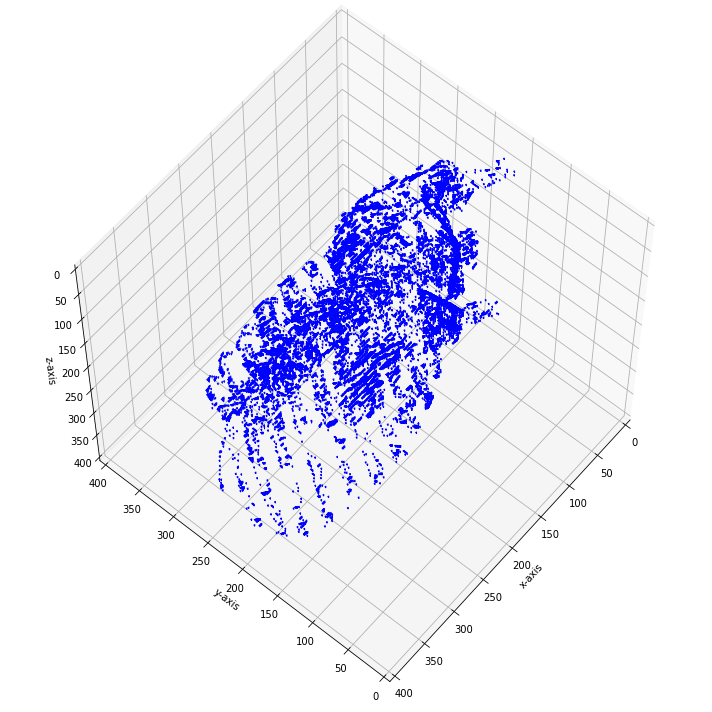

In [117]:
# マーチングキュープ法を実施
verts, faces, normals, values = measure.marching_cubes(img3d_threshold, 
                                                      level = 1,
                                                      spacing = (1, 0.781, 0.781),
                                                      step_size = 3,
                                                      mask = img3d_boolean)

# グラフを作成
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('b')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(0, 400)  
ax.set_ylim(0, 400)  
ax.set_zlim(0, 400)  

# 観察方向を指定
ax.view_init(elev=300, azim=-40)
plt.tight_layout()
plt.show()